In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt 
import seaborn as sns 
import pickle 

### FigureEight model training and dataset cleaning

In [2]:
#import figure 8 dataset.
data = pd.read_csv('../datasets/socialmedia-disaster-tweets-DFE.csv', encoding="ISO-8859-1")

In [4]:
data

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,778261105,True,golden,100,NaN,Relevant,0.7629,Relevant,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,5675678.0,NaN
10872,778261106,True,golden,90,NaN,Relevant,0.9203,Relevant,NaN,NaN,Police investigating after an e-bike collided ...,4234.0,NaN
10873,778261107,True,golden,102,NaN,Relevant,1.0000,Relevant,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,3242.0,NaN
10874,778261108,True,golden,96,NaN,Relevant,0.8419,Relevant,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,457.0,NaN


In [6]:
data['choose_one'].value_counts()

Not Relevant    6187
Relevant        4673
Can't Decide      16
Name: choose_one, dtype: int64

In [7]:
#Clenaing of regex and html. From doug on 11/1/19
data['text'] = data.text.map(lambda x: re.sub('\s[\/]?r\/[^s]+', ' ', x))
data['text'] = data.text.map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))

In [8]:
#Changing the target column to 1's and 0's for ease of viewing. Also converted 
data['choose_one'] = data['choose_one'].map({'Not Relevant':0, 'Relevant': 1, 'Can\'t Decide':0})

In [9]:
data

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,1,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,1,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,1,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,1,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,1,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,778261105,True,golden,100,NaN,1,0.7629,Relevant,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,5675678.0,NaN
10872,778261106,True,golden,90,NaN,1,0.9203,Relevant,NaN,NaN,Police investigating after an e-bike collided ...,4234.0,NaN
10873,778261107,True,golden,102,NaN,1,1.0000,Relevant,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,3242.0,NaN
10874,778261108,True,golden,96,NaN,1,0.8419,Relevant,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO),457.0,NaN


## Modeling

In [10]:
features = ['text', 'choose_one']
csv_dataframe = data[features]

In [53]:
csv_dataframe.to_csv('../datasets/model_trainer.csv', index=False)

In [11]:
#set up the varaibles for train test splitting.
X = data['text']
y = data['choose_one']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, stratify = y, random_state = 3)

### Logisitc Regression

In [44]:
logreg_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', LogisticRegression())
])

logreg_params={
    'cvec__min_df':[2, 4, 6],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'cvec__stop_words':['english', ENGLISH_STOP_WORDS],
    'model__C':[.001, .01, .1, .5, 1],
    'model__penalty':['l1','l2']
    }
gs_logreg = GridSearchCV(logreg_pipe, param_grid=logreg_params, cv = 5, n_jobs=-1, verbose=1)
gs_logreg.fit(X_train, y_train)


print(f'Best Params: {gs_logreg.best_params_}')
print(f'Linear Model Training Score: {gs_logreg.best_estimator_.score(X_train, y_train)}')
print(f'Linear Model Testing Score: {gs_logreg.best_estimator_.score(X_test, y_test)}')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   27.9s finished
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best Params: {'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': frozenset({'where', 'ltd', 'already', 'thereafter', 'together', 'thin', 'me', 'thence', 'been', 'down', 'detail', 'yet', 'otherwise', 'this', 'see', 'myself', 'am', 'cry', 'name', 'put', 'everywhere', 'hereupon', 'get', 'several', 'toward', 'once', 'if', 'us', 'again', 'fifteen', 'eg', 'many', 'across', 'sometime', 'whereafter', 'about', 'none', 'less', 'my', 'although', 'meanwhile', 'interest', 'much', 'hereafter', 'might', 'whoever', 'wherein', 'still', 'back', 'elsewhere', 'though', 'himself', 'everything', 'seemed', 'she', 'more', 'up', 'one', 'by', 'beside', 'would', 'via', 'he', 'thick', 'yourselves', 'most', 'also', 'afterwards', 'cannot', 'may', 'enough', 'except', 'that', 'than', 'nine', 'ourselves', 'those', 'along', 'front', 'whither', 'to', 'somewhere', 'each', 'its', 'sometimes', 'a', 'had', 'con', 'alone', 'six', 'in', 'per', 'should', 'empty', 'nevertheless', 'part', 'show', 'into', 'perhap

### Deciison Tree

In [150]:
dt_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', DecisionTreeClassifier())
])

dt_params={
    'cvec__min_df':[2, 4, 6],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'cvec__stop_words':['english', ENGLISH_STOP_WORDS],
    'model__max_depth':[3,4,5],
    'model__min_samples_split':[4,8,12],
    'model__min_samples_leaf':[5,10,15]
    }
gs_dt = GridSearchCV(dt_pipe, param_grid=dt_params, cv = 5, n_jobs=-1, verbose=1)
gs_dt.fit(X_train, y_train)
print(f'Best DT Params: {gs_dt.best_params_}')
print(f'Decision Tree Model Training Score: {gs_dt.best_estimator_.score(X_train, y_train)}')
print(f'Decision TreeModel Testing Score: {gs_dt.best_estimator_.score(X_test, y_test)}')

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  2.6min finished


Best DT Params: {'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'model__max_depth': 5, 'model__min_samples_leaf': 10, 'model__min_samples_split': 4}
Decision Tree Model Training Score: 0.6250343123799067
Decision TreeModel Testing Score: 0.6253481894150418


### AdaBoost

In [151]:
boost_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', AdaBoostClassifier())
])

boost_params={
    'cvec__min_df':[2, 4, 6],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'cvec__stop_words':['english', ENGLISH_STOP_WORDS],
    'model__base_estimator':[DecisionTreeClassifier(max_depth=5, min_samples_split=4, 
                    min_samples_leaf=10)],
    'model__n_estimators':[10,50,100],
    'model__random_state':[42],
    }
gs_boost = GridSearchCV(boost_pipe, param_grid=boost_params, cv = 5, n_jobs=-1, verbose=1)
gs_boost.fit(X_train, y_train)
print(f'Best AdaBoost Params: {gs_boost.best_params_}')
print(f'AdaBoost Model Training Score: {gs_boost.best_estimator_.score(X_train, y_train)}')
print(f'AdaBoost Model Testing Score: {gs_boost.best_estimator_.score(X_test, y_test)}')

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   39.0s finished


Best AdaBoost Params: {'cvec__min_df': 6, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'model__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'model__n_estimators': 50, 'model__random_state': 42}
AdaBoost Model Training Score: 0.8195168816909141
AdaBoost Model Testing Score: 0.7913649025069638


### Random Forest

In [47]:
rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', RandomForestClassifier())
])

rf_params={
    'cvec__min_df':[2, 4, 6],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'cvec__stop_words':['english', ENGLISH_STOP_WORDS],
    'model__n_estimators':[75, 250, 500],
    'model__max_features':[2, 3, 5],
    'model__max_depth':[5, 25, 75],
    'model__min_samples_split':[2,3,4],
    'model__min_samples_leaf':[5,10],
    'model__random_state': [3]
    }
gs_rf = GridSearchCV(rf_pipe, param_grid=rf_params, cv = 3, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)
print(f'Best Random Forest Params: {gs_rf.best_params_}')
print(f'Random Forest Model Training Score: {gs_rf.best_estimator_.score(X_train, y_train)}')
print(f'Random Forest Model Testing Score: {gs_rf.best_estimator_.score(X_test, y_test)}')

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 8748 out of 8748 | elapsed: 23.1min finished


Best Random Forest Params: {'cvec__min_df': 6, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'model__max_depth': 75, 'model__max_features': 5, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 250, 'model__random_state': 3}
Random Forest Model Training Score: 0.7452648915728795
Random Forest Model Testing Score: 0.7303621169916434


### Naive Bayes

In [49]:
nb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', MultinomialNB())
])

nb_params = {
    'cvec__min_df':[1,2,4, 6],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'cvec__stop_words':['english', ENGLISH_STOP_WORDS],
    'model__alpha': [0.1,1,10]
}

gs_nb = GridSearchCV(nb_pipe, param_grid=nb_params, cv=5, n_jobs=-1, verbose=1)
gs_nb.fit(X_train, y_train)
print(f'Best Naive Bayes Params: {gs_nb.best_params_}')
print(f'Naive Bayes Model Training Score: {gs_nb.best_estimator_.score(X_train, y_train)}')
print(f'Naive Bayes Model Testing Score: {gs_nb.best_estimator_.score(X_test, y_test)}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   23.4s finished


Best Naive Bayes Params: {'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'model__alpha': 1}
Naive Bayes Model Training Score: 0.8668679659621191
Naive Bayes Model Testing Score: 0.8041782729805014


### SVM

In [76]:
svm_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', SVC(gamma='scale'))
])

svm_params = {
    'cvec__min_df':[2,4,6],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'cvec__stop_words':['english', ENGLISH_STOP_WORDS],
    'model__C':[.1, 1, 10]  
}

gs_svm = GridSearchCV(svm_pipe, param_grid=svm_params, cv=5, n_jobs=10, verbose=1)
gs_svm.fit(X_train, y_train)

print(f'Best SVM Params: {gs_svm.best_params_}')
print(f'SVM Model Training Score: {gs_svm.best_estimator_.score(X_train, y_train)}')
print(f'SVM Model Testing Score: {gs_svm.best_estimator_.score(X_test, y_test)}')

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   22.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 270 out of 270 | elapsed:  3.3min finished


Best SVM Params: {'cvec__min_df': 4, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'model__C': 1}
SVM Model Training Score: 0.912983804556684
SVM Model Testing Score: 0.803899721448468


### XbgBoost

In [62]:
xbg_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('model', XGBClassifier())
])

xbg_params = {
    'cvec__min_df':[2,4,6],
    'cvec__stop_words':['english'],
    'model__n_estimators': [700, 1500],
    'model__min_samples_split':[2,4,6],
    'model__max_depth':[3,5]
}

gs_xbg = GridSearchCV(xbg_pipe, param_grid=xbg_params, cv=5, n_jobs=-1, verbose=1)
gs_xbg.fit(X_train, y_train)

print(f'Best XBG Params: {gs_xbg.best_params_}')
print(f'XBG Model Training Score: {gs_xbg.best_estimator_.score(X_train, y_train)}')
print(f'XBG Model Testing Score: {gs_xbg.best_estimator_.score(X_test, y_test)}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.4min finished


Best XBG Params: {'cvec__min_df': 2, 'cvec__stop_words': 'english', 'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 1500}
XBG Model Training Score: 0.8760636837771067
XBG Model Testing Score: 0.7919220055710307


### Voting Model

In [23]:
vote_model = Pipeline([
        ('cvec', CountVectorizer(stop_words='english', min_df=2, ngram_range=(1, 3))),     
        ('vote', VotingClassifier(
            estimators=[
                ("logreg", LogisticRegression(penalty='l2', C=0.5)),
                ("xgb", XGBClassifier(n_estimators=1500, min_samples_split = 2, max_depth= 5)), 
#                 ("svc", SVC(gamma='scale', kernel='rbf', C=1, probability=True)),
                ("nb", MultinomialNB(alpha=1))],
#                 ("rf", RandomForestClassifier(max_depth=75, min_samples_split=4, n_estimators=250))
                    voting='soft'))
         ])
vote_model.fit(X_train, y_train)
print(f'vote Model Training Score: {vote_model.score(X_train, y_train)}')
print(f'vote Model Testing Score: {vote_model.score(X_test, y_test)}')



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


vote Model Training Score: 0.8842986549547076
vote Model Testing Score: 0.815041782729805


In [175]:
#selected the voting classifier and saved to a pickle object file in order for testing on other data sets.
# with open('vote_model_save2', 'wb') as f:
#     pickle.dump(vote_model,f)


### Modeling review

In [31]:
#taken from previous ATX group that did poject


predictions = vote_model.predict(X_test)

def make_nice_conmat(y_test, preds):

    cmat = confusion_matrix(y_test, preds)
    print(f'Accuracy: {accuracy_score(y_test, preds)}')
    print(classification_report(y_test, preds))
    return pd.DataFrame(cmat, columns=['Predicted ' + str(i) for i in ['Regular Tweets','Disaster Tweets']],\
            index=['Actual ' + str(i) for i in ['Regular Tweets','Disaster Tweets']])

make_nice_conmat(y_test, predictions)

Accuracy: 0.815041782729805
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      2048
           1       0.87      0.67      0.76      1542

   micro avg       0.82      0.82      0.82      3590
   macro avg       0.83      0.80      0.80      3590
weighted avg       0.82      0.82      0.81      3590



,Predicted Regular Tweets,Predicted Disaster Tweets
Actual Regular Tweets,1892,156
Actual Disaster Tweets,508,1034


#### We can see that the model is a little higher than we would habve hoped it would be for its predictions of regular tweets that were actually disaster tweets. That 20% error in total accuracy makes for some improvement to be desired, however the overall score is almost 30% higher than the baseline. 

To further explore the accuracy of the model we took some other labeled datasets that focused on disaster scenarios to gauge the overall model's prediction abilities.
- This can be viewed in the **"Model Accuracy Testing"** notebook.

### EDA

- This just looks at a little bit of the words used in the training data set for the predictive model. For more EDA on the Harvey dataset see the notebook called "Harvey Day by Day EDA".

In [12]:
#set up the countvectorizer and created a dataframe of all the words in order to view the most common words.
cvec = CountVectorizer(stop_words='english', min_df=2, ngram_range = (1,3))

data_features = pd.DataFrame(cvec.fit_transform(X).todense(), 
                             columns=cvec.get_feature_names())

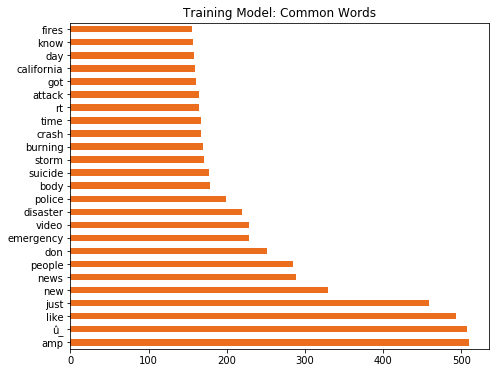

In [19]:
#Plotting the most common words used in the model training 
fig, (ax1) = plt.subplots(ncols=1, figsize = (7.5, 6))


data_features.loc[:, words[:25]].sum().plot.barh(ax = ax1, title = 'Training Model: Common Words', color = '#EB6E1F');

### Applying model to Harvey Dataset.

In [3]:
#reading in model
harvey_df = pd.read_csv('../datasets/Hurricane_Harvey - Kaggle.csv', encoding="ISO-8859-1")

In [4]:
harvey_df.columns

Index(['Unnamed: 0', 'ID', 'Likes', 'Replies', 'Retweets', 'Time', 'Tweet'], dtype='object')

In [5]:
harvey_df.drop(axis = 1, columns=['Unnamed: 0', 'Likes', 'Replies', 'Retweets', 'Time'], inplace=True)

In [6]:
harvey_df.shape

(399406, 2)

In [7]:
harvey_df.isna().sum()

ID       472
Tweet    490
dtype: int64

In [8]:
#dropping nan values. There is more than enough data in the dataset to
#afford dropping what is classified as nan above.
harvey_df.dropna(inplace=True)

In [9]:
#applied regex from Doug in order to clean the data.
harvey_df['Tweet'] = harvey_df['Tweet'].map(lambda x: x.lower())
harvey_df['Tweet'] = harvey_df['Tweet'].map(lambda x: re.sub('\s[\/]?r\/[^s]+', ' ', x))
harvey_df['Tweet'] = harvey_df['Tweet'].map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))
harvey_df['Tweet'] = harvey_df['Tweet'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

In [10]:
#opened the saved model from before to make predictions
with open('vote_model_save2', 'rb') as f:
    trained_model3 = pickle.load(f)

In [11]:
#applied model and created column in the dataframe to see the model's predictions
harvey_df['predictions'] = trained_model3.predict(harvey_df['Tweet'])

#### We can see below that the model is not quite as accurate as when applied to other testing datasets. 

In [12]:
harvey_df['predictions'].value_counts(normalize=True)

1    0.583078
0    0.416922
Name: predictions, dtype: float64

In [13]:
harvey_df['predictions'].value_counts()

1    232599
0    166317
Name: predictions, dtype: int64

In [14]:
#created dataframes to save to csvs to seperate tweets classified by the model as
#disaster tweets or not.
non_disaster_pred = harvey_df[harvey_df['predictions'] ==0]
disaster_pred = harvey_df[harvey_df['predictions'] ==1]

In [15]:
# disaster_pred.to_csv('../datasets/disaster_tweets.csv', index=False)

# non_disaster_pred.to_csv('../datasets/normal_tweets.csv', index = False)

### EDA on the seperate predicted tweet sets

In [30]:
#reading in tweets that were predicted to be disaster tweets
disaster_df = pd.read_csv('../datasets/disaster_tweets.csv')

In [31]:
disaster_df.dropna(inplace=True)

In [35]:
#reading in tweets that were preidted to be non-disaster tweets
regular_df = pd.read_csv('../datasets/normal_tweets.csv')

In [36]:
regular_df.dropna(inplace=True)

In [37]:
#creating variables to run through CountVectorizer for EDA
X_disaster = disaster_df['Tweet']

X_regular = regular_df['Tweet']

In [38]:
# created countvectorized dataframe to see the number of instances of words for EDA
data_features_disaster = pd.DataFrame(cvec.fit_transform(X_disaster).todense(), 
                             columns=cvec.get_feature_names())

data_features_regular = pd.DataFrame(cvec.fit_transform(X_regular).todense(), 
                             columns=cvec.get_feature_names())
#create list 
words_disaster = data_features_disaster.sum().sort_values(ascending=False).head(1000).index
words_regular = data_features_regular.sum().sort_values(ascending=False).head(1000).index

In [39]:
common_words_disaster = data_features_disaster.sum().sort_values(ascending = False)[1:25].index
common_words_regular = data_features_regular.sum().sort_values(ascending = False)[1:25].index

In [40]:
common_words_disaster

Index(['harvey', 'hurricane harvey', 'texas', 'twitter', 'com', 'twitter com',
       'storm', 'pic', 'pic twitter', 'pic twitter com', 'category',
       'hurricaneharvey', 'landfall', 'coast', 'news', 'winds', 'trump',
       'live', 'safe', 'category storm', 'path', 'mph', 'houston',
       'texas coast'],
      dtype='object')

In [41]:
common_words_regular

Index(['harvey', 'hurricane harvey', 'hurricaneharvey', 'twitter', 'com',
       'twitter com', 'pic', 'pic twitter com', 'pic twitter', 'trump',
       'texas', 'space', 'just', 'safe', 'seen', 'station', 'space station',
       'harvey seen', 'hurricane harvey seen', 'international',
       'international space', 'international space station', 'cupola',
       'seen cupola'],
      dtype='object')

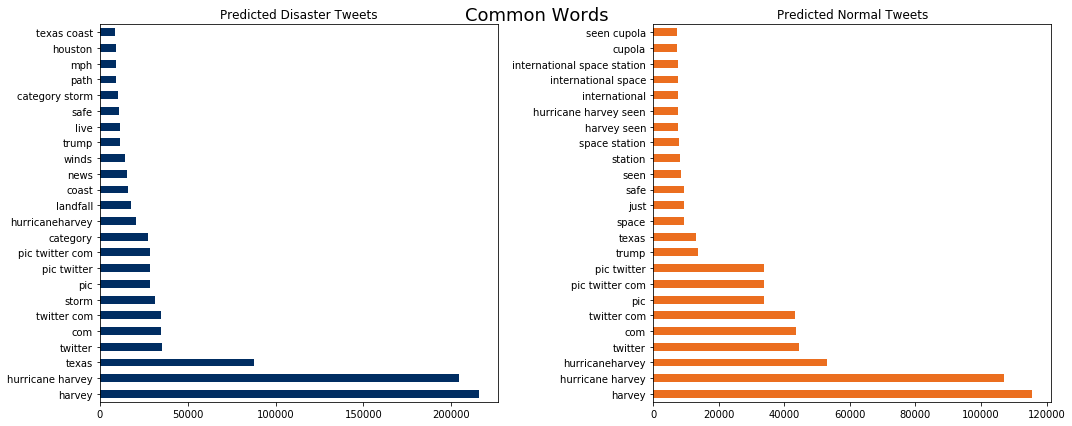

In [42]:
#took the common words and applied them to city specific sub-dataframes of the countvectorized data_features 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 6))

data_features_disaster.loc[:, common_words_disaster].sum().plot.barh(ax = ax1, title = 'Predicted Disaster Tweets', color = '#002D62'),

data_features_regular.loc[:, common_words_regular].sum().plot.barh(ax = ax2, title = 'Predicted Normal Tweets', color = '#EB6E1F'),

fig.suptitle('Common Words', fontsize=18)
plt.tight_layout();

#### inspecting the graphs its hard to see much difference between the datasets. We ended up taking each predicted class' tweets and randomly sampling it down to 10,000 each. From there we were able to see that the primary reason a tweet was classified as being a "disaster" tweet had to do with key words being used more than once in each tweet. 



#### From here we got stuck and tried to come up with different ideas that did not have the succesful outcomes we wanted. We were hoping that the model would have done a better job at helping find tweets that could be seen as urgent. Having 228,000 to sort through was just an unfesibile task. What we utlimately settled on for an idea with was to take the dataset that the model predicted to be disaster tweets and loop through a list of words that might be deemed to be used by people in crisis.

In [17]:
#dropping the predictions column from the created disaster_pred dataframe
#Accidently ran this twice ...
disaster_pred.drop(axis=1, columns=['predictions'], inplace=True)

KeyError: "['predictions'] not found in axis"

In [18]:
disaster_pred

,ID,Tweet
4,9.010000e+17,the name of the hurricane is harvey ... steve ...
7,9.010000e+17,summary for hurricane harvey at4/al092017
8,9.010000e+17,nasa: rt esa_eo: just in #sentinel3 measures #...
9,9.010000e+17,life-threatening hurricane harvey heads toward...
11,9.010000e+17,"everyone, please pray for texas. hurricane har..."
...,...,...
399400,9.030000e+17,salvation army in texas responds to catastroph...
399401,9.030000e+17,lawyers wanting to provide pro bono help in th...
399402,9.030000e+17,hurricane harvey: alabamas largest church alre...
399404,9.030000e+17,our thoughts are with our neighbors in the sou...


In [20]:
#list used to loop through in hopes of finding urgent tweets
emer_list = ['burning',
'distruction',
'blood',
'bleeding',
'hurt',
'die',
'dying',
'dead',
'death',
'drowning',
'flood'
'flooding',
'trapped',
'stuck',
'help',
'roof',
'injured',
'sick',
'scared',
'missing',
'rescue']

In [21]:
#taken from previous ATX group https://github.com/eamonious/disaster-tweet-classification
disaster_pred['urgent'] = disaster_pred['Tweet'].map(lambda x: 1 if sum([x.find(i) + 1 for i in emer_list])>0 else 0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
disaster_pred['urgent'].value_counts()

0    218681
1     13918
Name: urgent, dtype: int64

In [23]:
urgent_tweets = disaster_pred[disaster_pred['urgent'] == 1]

In [24]:
# urgent_tweets.to_csv('../datasets/urgent_tweets.csv', index=False)

In [25]:
X_urgent = urgent_tweets['Tweet']

In [26]:
cvec = CountVectorizer(stop_words='english', min_df=2, ngram_range = (1,3), max_features=1500)

data_features_urgent = pd.DataFrame(cvec.fit_transform(X_urgent).todense(), 
                             columns=cvec.get_feature_names())

words_disaster = data_features_urgent.sum().sort_values(ascending=False).head(1000).index

In [27]:
words_disaster[:25]

Index(['hurricane', 'harvey', 'hurricane harvey', 'help', 'texas', 'victims',
       'twitter', 'com', 'twitter com', 'pic', 'pic twitter com',
       'pic twitter', 'help victims', 'storm', 'victims hurricane',
       'victims hurricane harvey', 'people', 'help hurricane',
       'help victims hurricane', 'dead', 'help hurricane harvey', 'death',
       'heres', 'stuck', 'houston'],
      dtype='object')

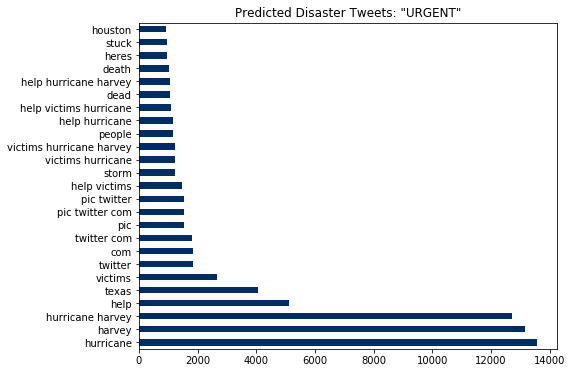

In [28]:
fig, (ax1) = plt.subplots(ncols=1, figsize = (7.5, 6))


data_features_urgent.loc[:, words_disaster[:25]].sum().plot.barh(ax = ax1, title = 'Predicted Disaster Tweets: \"URGENT\"', color = '#002D62');

### Utlimately the project needs a few more steps to be successful. The model looks like it has some promise, but there neeeds to be some better itterations in order to improve its ability to find "urgent" tweets on it's own. After looking through the urgent tweet set, it was clear it filtered out more of the news stories and retweets to find more real people's tweets. However it still was not effective enough.